In [ ]:
# ! pip uninstall -y numpy pandas scikit-learn spacy torch torchvision transformers
! pip install numpy pandas scikit-learn spacy torch torchvision transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjit

In [ ]:
import numpy as np
import pandas as pd
import spacy
import torch
print(np.__version__)

2.0.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
import spacy
from tqdm import tqdm
import string

In [ ]:
# --- Settings ---
MODEL_NAME = "almanach/camembertav2-base"
MAX_TOKENS = 512
N_NEIGHBORS = 8

# 1. Define the name of your CSV file
TARGET_FILE = "/content/drive/MyDrive/_thesis_dogwhistles/Cosine-distance-stats/dw-variance/only-dws.csv"

# 2. Use pandas to read the file and get the list of targets from the "target" column
targets_df = pd.read_csv(TARGET_FILE)
targets = targets_df['target'].dropna().unique().tolist()

# The 'targets' variable now holds your list of targets
# print(targets)

# --- Load model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModel.from_pretrained(MODEL_NAME).to(device).eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/442M [00:00<?, ?B/s]

In [ ]:
! python -m spacy download fr_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 103.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy

In [ ]:
# --- Load stopwords and lemmatizer ---
nlp = spacy.load("fr_core_news_sm")
STOPWORDS = set(spacy.lang.fr.stop_words.STOP_WORDS)

In [ ]:
import random
# set seed for deterministic results
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [ ]:
import torch
import pandas as pd
import numpy as np
import spacy
import re
import os
import csv
import pickle
from collections import defaultdict
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

# ------------------
# 1. SETUP & CONFIGURATION
# ------------------
# --- File Paths ---
C1_PATH = "/content/drive/MyDrive/_thesis_dogwhistles/Compare-embeddings/corpora/c1-left.csv"
C2_PATH = "/content/drive/MyDrive/_thesis_dogwhistles/Compare-embeddings/corpora/c2-right.csv"
TARGETS_CSV_PATH = "/content/drive/MyDrive/_thesis_dogwhistles/Cosine-distance-stats/dw-variance/only-dws.csv" # Your CSV file with a 'target' column
TEXT_COLUMN = "content"
OUTPUT_DIR = "/content/drive/MyDrive/_thesis_dogwhistles/Compare-embeddings/results/NeighborAnalysis/"

# --- Intermediate & Final Files ---
VOCAB_C1_PKL_PATH = os.path.join(OUTPUT_DIR, "full_vocab_c1.pkl")
VOCAB_C2_PKL_PATH = os.path.join(OUTPUT_DIR, "full_vocab_c2.pkl")
NEIGHBORS_CSV_PATH = os.path.join(OUTPUT_DIR, "dw_neighbor_differences.csv")

os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Model & Device Setup ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
TOKENIZER = AutoTokenizer.from_pretrained("almanach/camembertv2-base")
MODEL = AutoModel.from_pretrained("almanach/camembertv2-base").to(DEVICE).eval()
NLP = spacy.load("fr_core_news_sm", disable=["parser", "ner"])
torch.manual_seed(42)
np.random.seed(42)

# ------------------
# 2. ANALYSIS STAGES
# ------------------

def build_and_save_vocab_incrementally(corpus_path, vocab_pkl_path, min_freq=10):
    """
    Builds a complete, lemmatized vocabulary embedding from a corpus, saving progress incrementally.
    """
    print(f"\n--- Building Full Lemmatized Vocabulary for {os.path.basename(corpus_path)} ---")
    df = pd.read_csv(corpus_path, usecols=[TEXT_COLUMN])
    texts = [str(text) for text in df[TEXT_COLUMN].dropna().tolist()]

    start_index = 0
    all_word_embeddings = defaultdict(list)

    if os.path.exists(vocab_pkl_path):
        print(f"Found existing checkpoint. Loading progress from {vocab_pkl_path}...")
        try:
            with open(vocab_pkl_path, 'rb') as f:
                saved_data = pickle.load(f)
                all_word_embeddings = saved_data['embeddings']
                start_index = saved_data['_last_index']
                print(f"Resuming from index {start_index}.")
        except Exception as e:
            print(f"Warning: Could not load checkpoint file. Starting from scratch. Error: {e}")

    chunk_size = 5000  # Process 5000 tweets at a time before saving

    # Use NLP.pipe for efficient spaCy processing
    for i in tqdm(range(start_index, len(texts), chunk_size), desc="Processing in chunks"):
        end = min(i + chunk_size, len(texts))
        chunk_docs = NLP.pipe(texts[i:end])

        for doc in chunk_docs:
            inputs = TOKENIZER(doc.text, return_tensors="pt", truncation=True, max_length=512, return_offsets_mapping=True).to(DEVICE)
            offsets = inputs.pop("offset_mapping").squeeze(0).tolist()

            with torch.no_grad():
                outputs = MODEL(**inputs).last_hidden_state.squeeze(0)

            # Align transformer tokens back to spaCy tokens to get lemmas
            spacy_token_idx = -1
            for j, (start, end_offset) in enumerate(offsets):
                if start == end_offset: continue # Skip special tokens
                # Find the spaCy token that this transformer token belongs to
                if spacy_token_idx < len(doc) - 1 and start >= doc[spacy_token_idx + 1].idx:
                    spacy_token_idx += 1

                if spacy_token_idx < len(doc):
                    token = doc[spacy_token_idx]
                    if token.is_alpha and not token.is_stop and len(token.text) > 2:
                        all_word_embeddings[token.lemma_.lower()].append(outputs[j].cpu().numpy())

        # Save progress at the end of each chunk
        with open(vocab_pkl_path, 'wb') as f:
            pickle.dump({'embeddings': all_word_embeddings, '_last_index': end}, f)

    print("Finished processing all chunks. Averaging embeddings...")
    final_vocab = {
        lemma: np.array(embs).mean(axis=0)
        for lemma, embs in all_word_embeddings.items()
        if len(embs) >= min_freq
    }

    with open(vocab_pkl_path, 'wb') as f:
        pickle.dump(final_vocab, f)
    print(f"Final vocabulary with {len(final_vocab)} lemmas saved to {vocab_pkl_path}.")
    return final_vocab


def run_neighbor_comparison(vocab_c1_path, vocab_c2_path, neighbors_csv_path, targets, n_neighbors=8):
    """Compares semantic neighbors and saves the results to CSV progressively."""
    print("\n--- Comparing Semantic Neighbors ---")
    with open(vocab_c1_path, 'rb') as f:
        vocab_c1 = pickle.load(f)
    with open(vocab_c2_path, 'rb') as f:
        vocab_c2 = pickle.load(f)

    all_tokens_c1 = list(vocab_c1.keys())
    all_embs_c1 = np.array(list(vocab_c1.values()))
    all_tokens_c2 = list(vocab_c2.keys())
    all_embs_c2 = np.array(list(vocab_c2.values()))

    headers = ["lemma", "shared_neighbors", "diff_neighbors", "neighbors_c1", "neighbors_c2"]

    with open(neighbors_csv_path, 'w', newline='', encoding='utf-8') as f:
        writer = csv.DictWriter(f, fieldnames=headers)
        writer.writeheader()

        for target in tqdm(targets, desc="Comparing neighbors and saving results"):
            if target in vocab_c1 and target in vocab_c2:
                sims_c1 = cosine_similarity([vocab_c1[target]], all_embs_c1)[0]
                top_indices_c1 = sims_c1.argsort()[-n_neighbors-1:-1][::-1]
                neighbors_c1 = set(all_tokens_c1[i] for i in top_indices_c1)

                sims_c2 = cosine_similarity([vocab_c2[target]], all_embs_c2)[0]
                top_indices_c2 = sims_c2.argsort()[-n_neighbors-1:-1][::-1]
                neighbors_c2 = set(all_tokens_c2[i] for i in top_indices_c2)

                overlap = neighbors_c1.intersection(neighbors_c2)

                writer.writerow({
                    "lemma": target,
                    "shared_neighbors": len(overlap),
                    "diff_neighbors": n_neighbors - len(overlap),
                    "neighbors_c1": sorted(list(neighbors_c1)),
                    "neighbors_c2": sorted(list(neighbors_c2))
                })

# ------------------
# 3. MAIN EXECUTION
# ------------------
if __name__ == '__main__':
    targets_df = pd.read_csv(TARGETS_CSV_PATH)
    targets = sorted(list(set(targets_df['target'].dropna().str.lower())))
    print(f"Loaded {len(targets)} unique targets.")

    # --- Execute Pipeline ---

    # Stage 1: Build full vocabulary for Corpus 1 (resumable)
    build_and_save_vocab_incrementally(C1_PATH, VOCAB_C1_PKL_PATH)

    # Stage 2: Build full vocabulary for Corpus 2 (resumable)
    build_and_save_vocab_incrementally(C2_PATH, VOCAB_C2_PKL_PATH)

    # Stage 3: Run the neighbor comparison
    run_neighbor_comparison(VOCAB_C1_PKL_PATH, VOCAB_C2_PKL_PATH, NEIGHBORS_CSV_PATH, targets)

    print(f"\n🎉 Analysis complete! Neighbor comparison saved to '{NEIGHBORS_CSV_PATH}'.")

Using device: cuda


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/963 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/447M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at almanach/camembertv2-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded 15 unique targets.

--- Building Full Lemmatized Vocabulary for c1-left.csv ---
Found existing checkpoint. Loading progress from /content/drive/MyDrive/_thesis_dogwhistles/Compare-embeddings/results/NeighborAnalysis/full_vocab_c1.pkl...


Processing in chunks: 100%|██████████| 34/34 [49:52<00:00, 88.01s/it]


Finished processing all chunks. Averaging embeddings...
Final vocabulary with 20063 lemmas saved to /content/drive/MyDrive/_thesis_dogwhistles/Compare-embeddings/results/NeighborAnalysis/full_vocab_c1.pkl.

--- Building Full Lemmatized Vocabulary for c2-right.csv ---


Processing in chunks: 100%|██████████| 33/33 [48:04<00:00, 87.41s/it] 


Finished processing all chunks. Averaging embeddings...
Final vocabulary with 18813 lemmas saved to /content/drive/MyDrive/_thesis_dogwhistles/Compare-embeddings/results/NeighborAnalysis/full_vocab_c2.pkl.

--- Comparing Semantic Neighbors ---


Comparing neighbors and saving results: 100%|██████████| 15/15 [00:01<00:00, 12.59it/s]



🎉 Analysis complete! Neighbor comparison saved to '/content/drive/MyDrive/_thesis_dogwhistles/Compare-embeddings/results/NeighborAnalysis/dw_neighbor_differences.csv'.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Found 3 of the specified words. Generating graphs...
Graph for 'fascisme' saved as 'neighbors_fascisme.png'


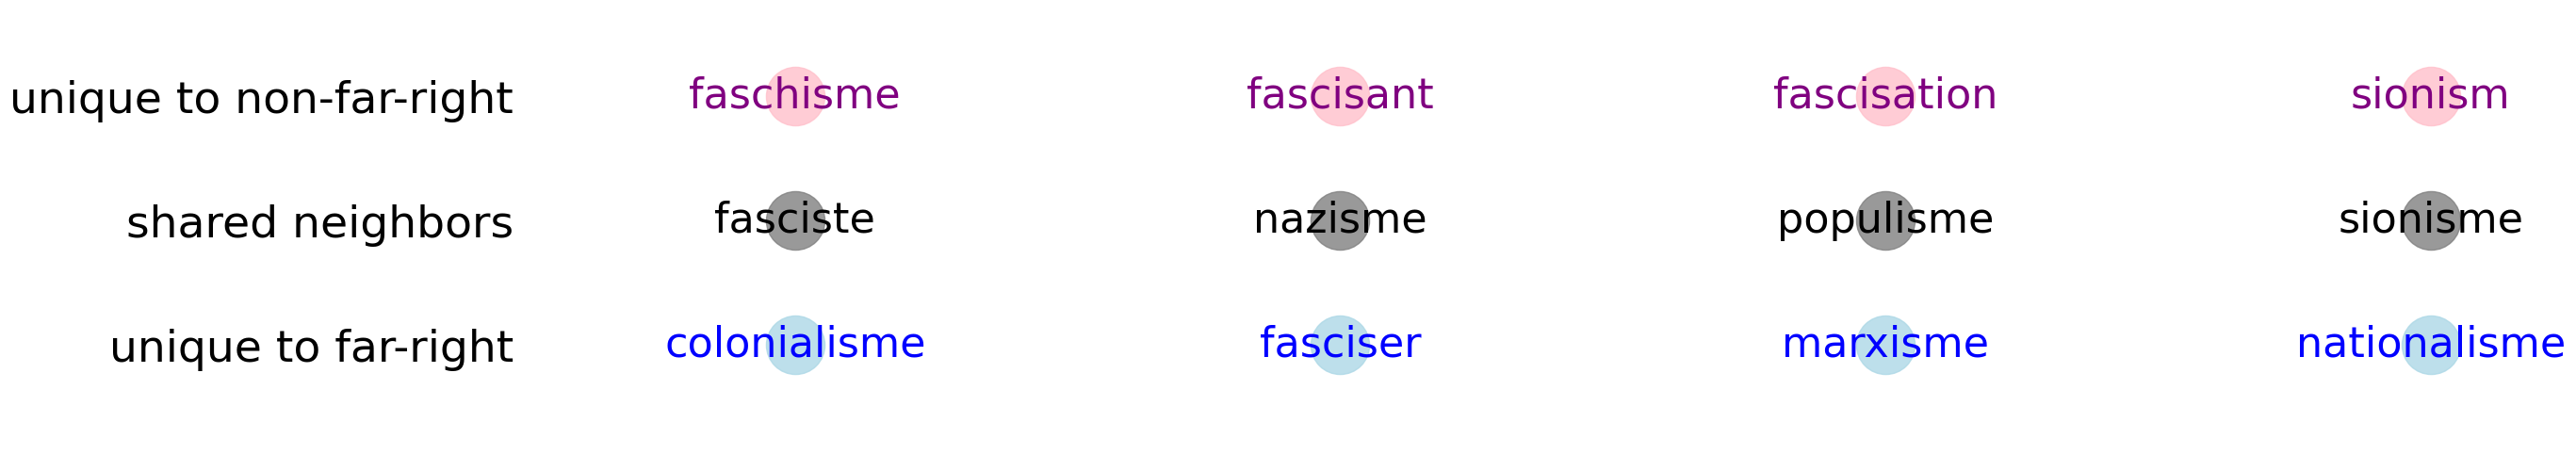

Graph for 'racine' saved as 'neighbors_racine.png'


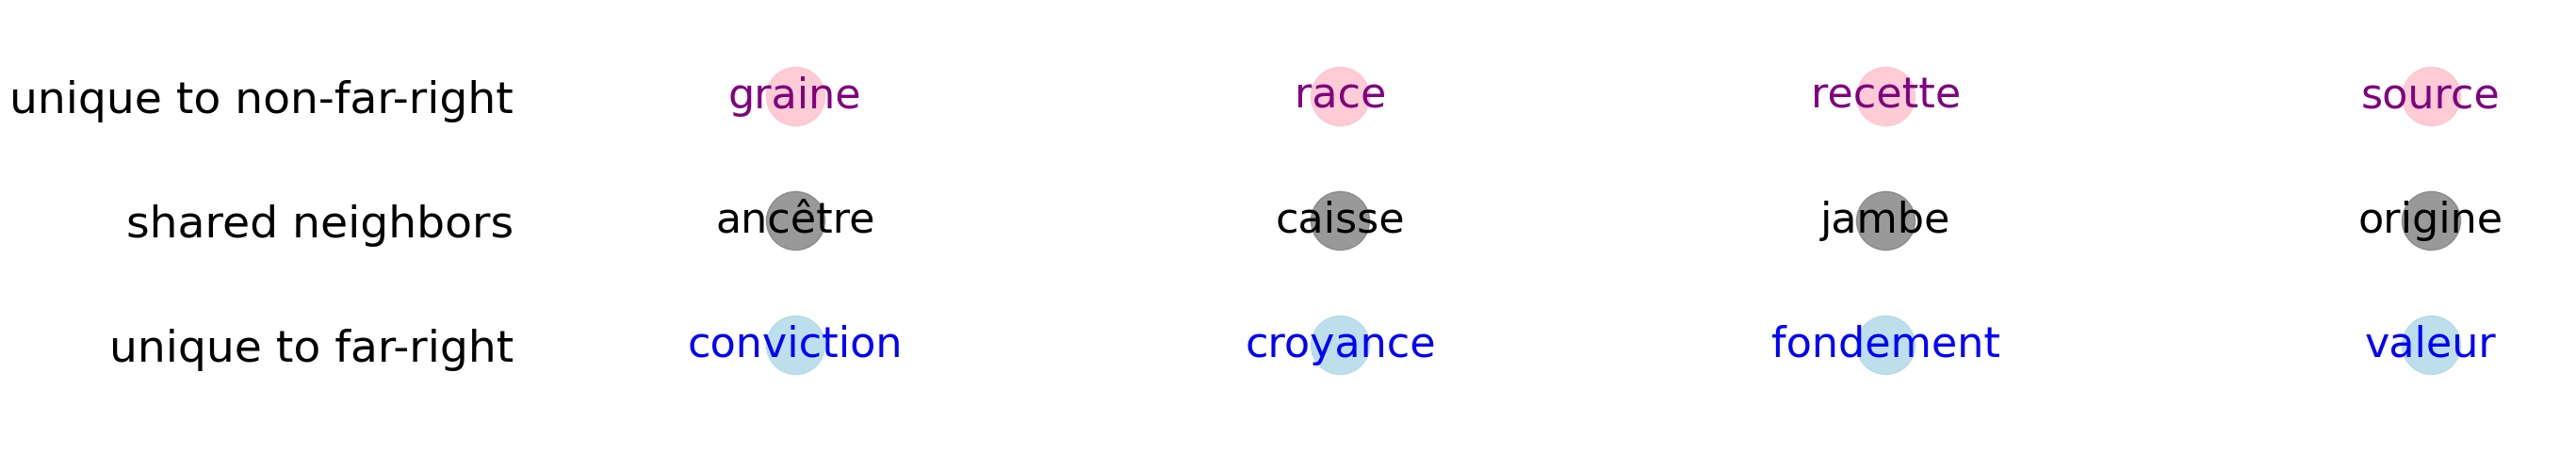

Graph for 'wokisme' saved as 'neighbors_wokisme.png'


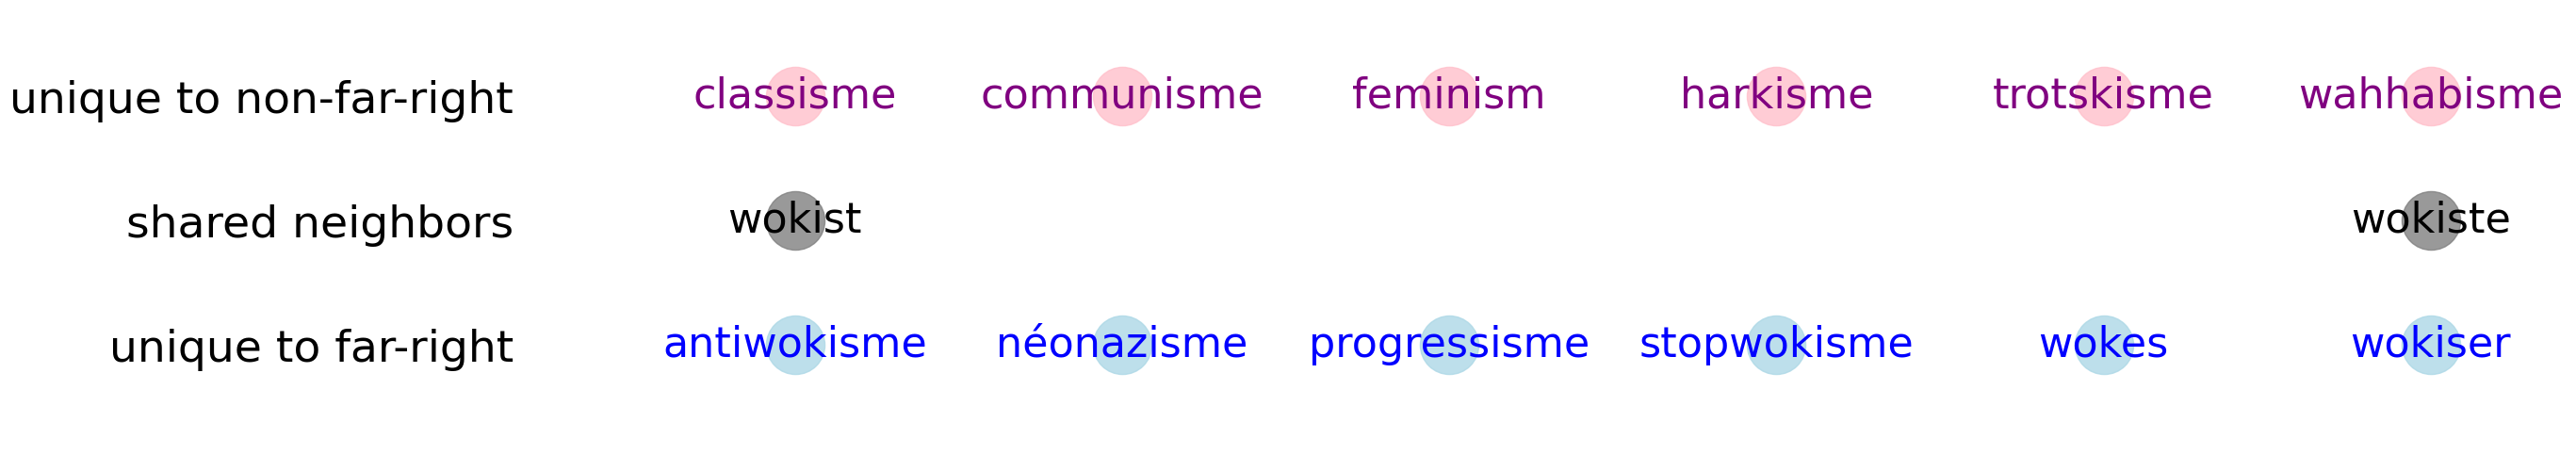

In [ ]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import numpy as np


# --- 1. Define Words and File Paths ---
# The specific words you want to create graphs for
target_words_to_plot = ['wokisme', 'racine', 'fascisme']

# The path to your completed neighbor analysis file
file_path = '/content/drive/MyDrive/_thesis_dogwhistles/Compare-embeddings/results/NeighborAnalysis/dw_neighbor_differences.csv'


# --- 2. Load and Prepare the Data ---
try:
    df = pd.read_csv(file_path)

    # Filter the DataFrame to only include the target words
    plot_df = df[df['lemma'].isin(target_words_to_plot)].copy()

    if plot_df.empty:
        print(f"Warning: None of the specified words {target_words_to_plot} were found in the results file.")
    else:
        print(f"Found {len(plot_df)} of the specified words. Generating graphs...")

    # --- 3. Loop Through Each Word to Create a Plot ---
    for _, row in plot_df.iterrows():
        lemma = row['lemma']

        neighbors_c1 = set(ast.literal_eval(row['neighbors_c1']))
        neighbors_c2 = set(ast.literal_eval(row['neighbors_c2']))

        shared_neighbors_set = neighbors_c1.intersection(neighbors_c2)
        unique_c1_set = neighbors_c1 - shared_neighbors_set
        unique_c2_set = neighbors_c2 - shared_neighbors_set

        shared_neighbors = sorted(list(shared_neighbors_set))
        unique_c1 = sorted(list(unique_c1_set))
        unique_c2 = sorted(list(unique_c2_set))

       # --- Create the Visualization ---
        fig, ax = plt.subplots(figsize=(28, 6))

        y_c1, y_shared, y_c2 = 2, 1, 0
        margin = 0.2

        # --- THIS SECTION IS CORRECTED ---
        # Set the end of the plotting range to match the xlim
        plot_area_end = 1.4
        x_c1 = np.linspace(margin, plot_area_end, len(unique_c1)) if unique_c1 else []
        x_shared = np.linspace(margin, plot_area_end, len(shared_neighbors)) if shared_neighbors else []
        x_c2 = np.linspace(margin, plot_area_end, len(unique_c2)) if unique_c2 else []

        # --- END OF UPDATE ---

        ax.scatter(x_c1, [y_c1] * len(unique_c1), s=2000, alpha=0.8, color='pink')
        ax.scatter(x_shared, [y_shared] * len(shared_neighbors), s=2000, alpha=0.8, color='gray')
        ax.scatter(x_c2, [y_c2] * len(unique_c2), s=2000, alpha=0.8, color='lightblue')

        for i, word in enumerate(unique_c1):
            ax.text(x_c1[i], y_c1, word, ha='center', va='center', fontsize=32, color='purple')
        for i, word in enumerate(shared_neighbors):
            ax.text(x_shared[i], y_shared, word, ha='center', va='center', fontsize=32, color='black')
        for i, word in enumerate(unique_c2):
            ax.text(x_c2[i], y_c2, word, ha='center', va='center', fontsize=32, color='blue')

        # --- 4. Clean Up and Customize the Plot ---
        ax.set_xticks([])
        ax.set_xlabel('')

        # Set y-axis ticks and labels
        ax.set_yticks([y_c2, y_shared, y_c1])
        ax.set_yticklabels(
            ['unique to far-right', 'shared neighbors', 'unique to non-far-right'],
            fontsize=34
        )

        for spine in ['top', 'bottom', 'right', 'left']:
            ax.spines[spine].set_visible(False)

        ax.tick_params(left=False)

        # --- THIS SECTION IS UPDATED ---
        # Set the x-axis limits to create space on the left for the labels
        plt.xlim(0, 1.5)
        # --- END OF UPDATE ---
        plt.ylim(-0.8, 2.7)

        plot_filename = f'neighbors_{lemma}.png'
        plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
        print(f"Graph for '{lemma}' saved as '{plot_filename}'")
        plt.show()

except FileNotFoundError:
    print(f"Error: The file was not found at '{file_path}'. Please check the path and filename.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
import glob
import zipfile
from google.colab import files

# --- 1. Define the name for the zip file ---
zip_filename = 'all_neighbor_plots.zip'

# --- 2. Find all the plot files you created ---
plot_files = glob.glob('neighbors_*.png')

if not plot_files:
    print("No plot files ('neighbors_*.png') found to download.")
else:
    print(f"Found {len(plot_files)} plots to archive.")
    # --- 3. Create a zip archive ---
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for file in plot_files:
            zipf.write(file)

    print(f"All plots have been compressed into '{zip_filename}'.")

    # --- 4. Download the single zip file ---
    print("Downloading the zip file...")
    files.download(zip_filename)

Found 3 plots to archive.
All plots have been compressed into 'all_neighbor_plots.zip'.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>